In [6]:
# single channel mask


import os
import skimage.io
import cv2
from matplotlib import pyplot as plt
import numpy as np
import skimage.filters
import skimage.morphology

# Paths
image_dir = r'C:\Users\k54739\Today_data\segmentation\test_img'  # Input image directory
mask_dir = r'C:\Users\k54739\Today_data\segmentation\test_mask'  # Output mask directory

os.makedirs(mask_dir, exist_ok=True)  # Ensure mask directory exists

def process_image(image_path):
    # Load the image
    image = skimage.io.imread(image_path)

    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = image

    # Convert to 8-bit format
    img_gray_8bit = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Blur using bilateral filter
    blur = cv2.bilateralFilter(img_gray_8bit, 50, 40, 40)

    # Apply Otsu thresholding
    t = skimage.filters.threshold_otsu(blur)
    binary_mask = blur > t

    # Remove small objects
    filtered_mask = skimage.morphology.remove_small_objects(binary_mask, 10000)

    return img_gray_8bit, filtered_mask

def save_mask_as_16bit_tiff(mask, save_path):
    """
    Save the binary mask as a 16-bit TIFF file with background as black (0)
    and segmented object as white (65535).
    """
    # Invert mask: Background (False) -> 0, Object (True) -> 65535
    mask_16bit = mask.astype(np.uint16) * 65535
    skimage.io.imsave(save_path, mask_16bit, check_contrast=False)  # Save as 16-bit TIFF

# Process all images
for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    
    # Skip non-image files
    if not image_name.lower().endswith(('.tiff', '.tif')):
        continue

    # Process image
    img_gray_8bit, mask = process_image(image_path)

    # Save the mask
    mask_path = os.path.join(mask_dir, os.path.splitext(image_name)[0] + '_mask.tiff')  # Save as .tiff
    save_mask_as_16bit_tiff(mask, mask_path)


In [8]:
# 3 channel

import os
import skimage.io
import cv2
from matplotlib import pyplot as plt
import numpy as np
import skimage.filters
import skimage.morphology

# Paths
image_dir = r'C:\Users\k54739\Today_data\segmentation\test_img'  # Input image directory
mask_dir = r'C:\Users\k54739\Today_data\segmentation\test_mask'  # Output mask directory

os.makedirs(mask_dir, exist_ok=True)  # Ensure mask directory exists

def process_image(image_path):
    # Load the image
    image = skimage.io.imread(image_path)

    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = image

    # Convert to 8-bit format
    img_gray_8bit = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Blur using bilateral filter
    blur = cv2.bilateralFilter(img_gray_8bit, 50, 40, 40)

    # Apply Otsu thresholding
    t = skimage.filters.threshold_otsu(blur)
    binary_mask = blur > t

    # Remove small objects
    filtered_mask = skimage.morphology.remove_small_objects(binary_mask, 10000)

    return img_gray_8bit, filtered_mask

def save_mask_as_16bit_3channel_tiff(mask, save_path):
    """
    Save the binary mask as a 16-bit 3-channel TIFF file with background as black (0)
    and segmented object as white (65535).
    """
    # Convert mask to 16-bit: Background (False) -> 0, Object (True) -> 65535
    mask_16bit = mask.astype(np.uint16) * 65535
    
    # Create a 3-channel version of the mask
    mask_3channel = np.stack([mask_16bit] * 3, axis=-1)  # Stack mask along the last dimension

    # Reorder dimensions to (3, height, width) for compatibility
    mask_3channel = np.transpose(mask_3channel, (2, 0, 1))  # Convert (height, width, 3) to (3, height, width)

    # Save the 3-channel mask as a TIFF file
    skimage.io.imsave(save_path, mask_3channel, check_contrast=False)

# Process all images
for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    
    # Skip non-image files
    if not image_name.lower().endswith(('.tiff', '.tif')):
        continue

    # Process image
    img_gray_8bit, mask = process_image(image_path)

    # Save the 3-channel mask
    mask_path = os.path.join(mask_dir, os.path.splitext(image_name)[0] + '_mask.tiff')  # Save as .tiff
    save_mask_as_16bit_3channel_tiff(mask, mask_path)


In [7]:
import numpy as np
import skimage.io

# Load the TIFF mask image
mask_path = r'C:\Users\k54739\Today_data\segmentation\test_mask\cond10_ds_41_E10-T01_mask.tiff'  # Replace with your mask path
mask = skimage.io.imread(mask_path)

# Get unique pixel values and their counts
unique_values, counts = np.unique(mask, return_counts=True)

# Print unique pixel values and their count
print("Unique Pixel Values:", unique_values)
print("Number of Unique Pixel Values:", len(unique_values))
print("Counts of Each Pixel Value:", counts)


Unique Pixel Values: [    0 65535]
Number of Unique Pixel Values: 2
Counts of Each Pixel Value: [4250994 8405754]


In [2]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\k54739/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [3]:
print(model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tifffile as tiff
from torchvision.transforms.functional import resize

pretrained model is input channel 3 output channel = 1 
hence our target or output iamge mask have is single channel

In [2]:


class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):  # Removed transform for simplicity
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(('.tiff', '.tif'))]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(image_name)[0] + '_mask.tiff')  # Match naming

        # Load image and mask
        image = tiff.imread(image_path)
        mask = tiff.imread(mask_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {image_path} does not have exactly 3 layers.")
        mask = mask[np.newaxis, ...] # adding axis so that 2054, 2054 becomes 1, 2054, 2054 so that we can do resizee properly.

        # Normalize image and mask
        image = image.astype(np.float32) / 65535.0
        mask = mask.astype(np.float32) / 65535.0

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        # Resize image and mask to 256x256
        image = resize(image, size=(96, 96))
        mask = resize(mask, size=(96, 96))

        return image, mask


In [3]:
# Paths
image_dir = r'C:\Users\k54739\Today_data\segmentation\test_img'
mask_dir = r'C:\Users\k54739\Today_data\segmentation\test_mask'

# Split dataset into train and validation
all_images = os.listdir(image_dir)
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

# Train and validation datasets
train_dataset = SegmentationDataset(image_dir, mask_dir) #(image_dir, mask_dir, transform=transform)
val_dataset = SegmentationDataset(image_dir, mask_dir)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [4]:
# Load pretrained U-Net model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use Binary Cross-Entropy Loss with logits
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



Using cache found in C:\Users\k54739/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [5]:
# Initialize lists to store losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/100, Train Loss: 0.6436, Val Loss: 0.6443
Epoch 2/100, Train Loss: 0.6006, Val Loss: 0.5575
Epoch 3/100, Train Loss: 0.5747, Val Loss: 0.5185
Epoch 4/100, Train Loss: 0.5564, Val Loss: 0.5119
Epoch 5/100, Train Loss: 0.5438, Val Loss: 0.5110
Epoch 6/100, Train Loss: 0.5339, Val Loss: 0.5118
Epoch 7/100, Train Loss: 0.5253, Val Loss: 0.5116
Epoch 8/100, Train Loss: 0.5166, Val Loss: 0.5128
Epoch 9/100, Train Loss: 0.5126, Val Loss: 0.5155
Epoch 10/100, Train Loss: 0.5091, Val Loss: 0.5140
Epoch 11/100, Train Loss: 0.5062, Val Loss: 0.5113
Epoch 12/100, Train Loss: 0.5038, Val Loss: 0.5099
Epoch 13/100, Train Loss: 0.5016, Val Loss: 0.5095
Epoch 14/100, Train Loss: 0.4992, Val Loss: 0.5108
Epoch 15/100, Train Loss: 0.4969, Val Loss: 0.5135
Epoch 16/100, Train Loss: 0.4947, Val Loss: 0.5164
Epoch 17/100, Train Loss: 0.4927, Val Loss: 0.5177
Epoch 18/100, Train Loss: 0.4905, Val Loss: 0.5170
Epoch 19/100, Train Loss: 0.4884, Val Loss: 0.5152
Epoch 20/100, Train Loss: 0.4864, Val Lo

KeyboardInterrupt: 

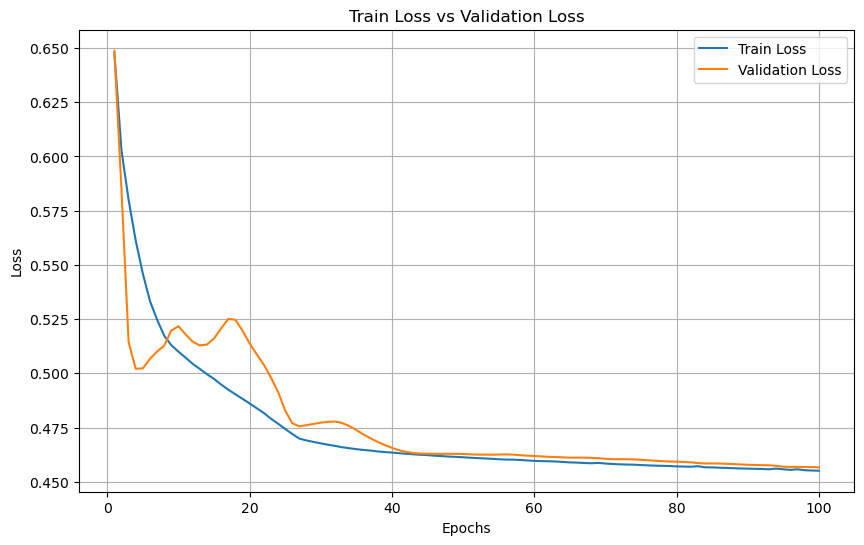

In [6]:
# Plotting the losses
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

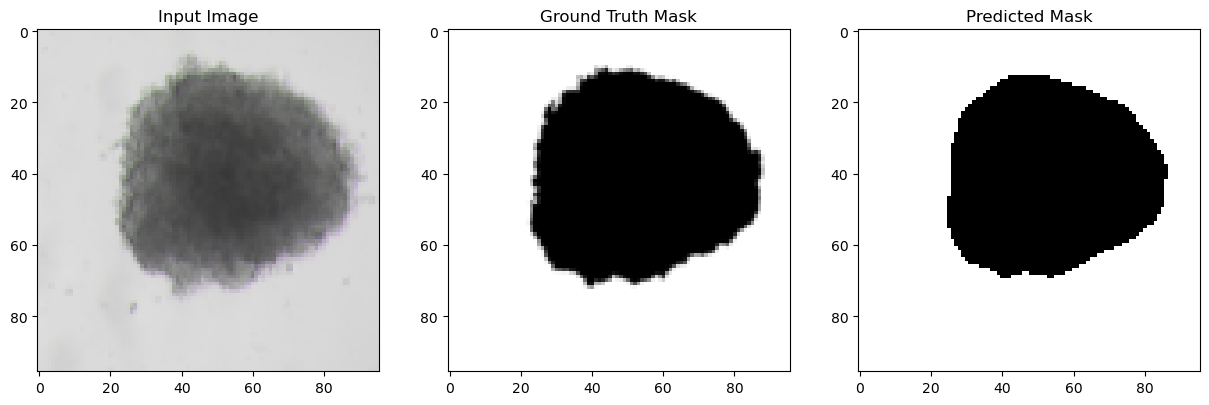

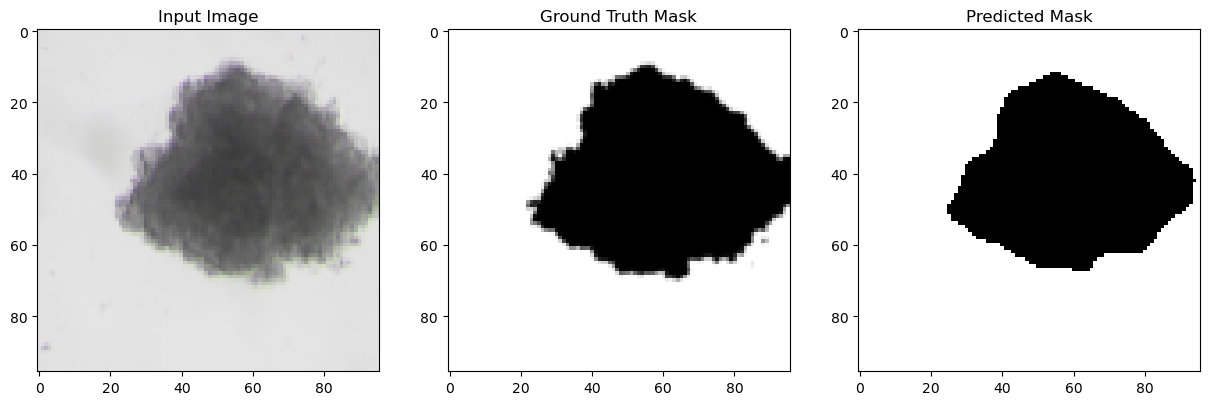

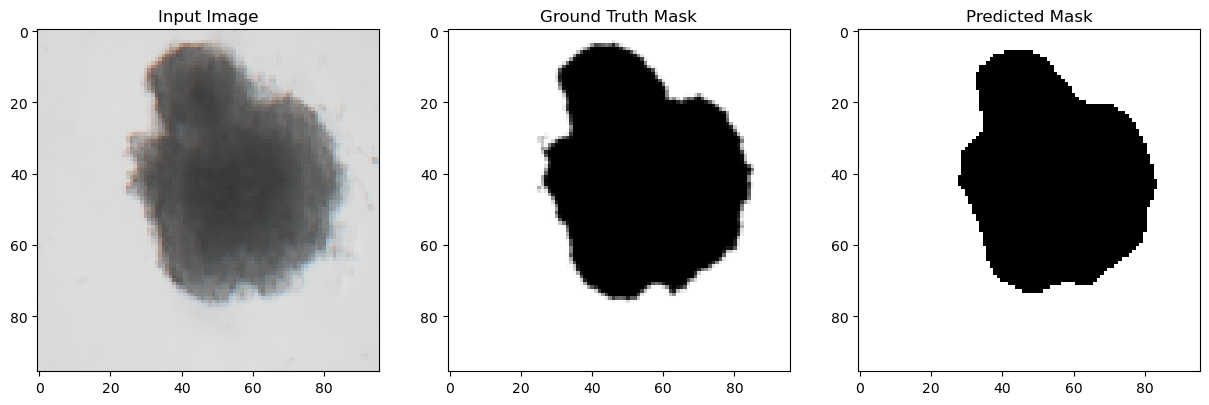

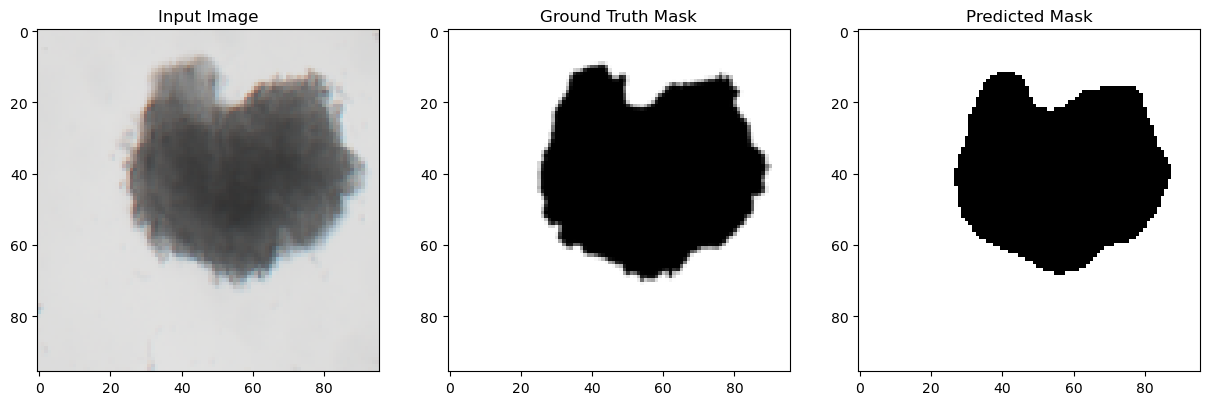

In [7]:

# Save model
#torch.save(model.state_dict(), 'unet_segmentation_model.pth')

# Visualize results
model.eval()
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)
outputs = model(images)
predicted_masks = (torch.sigmoid(outputs) > 0.5).float()

for i in range(len(images)):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(images[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(masks[i].cpu().squeeze(0).numpy(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_masks[i].cpu().squeeze(0).numpy(), cmap='gray')
    plt.show()


import os
import tifffile as tiff

# Path to the directory containing TIFF images
image_dir = r'C:\Users\k54739\Today_data\segmentation\test_mask'

# Iterate over all files in the directory
for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    
    # Skip non-image files
    if not image_name.lower().endswith(('.tiff', '.tif')):
        continue
  

    # Load the image and check its shape
    image = tiff.imread(image_path)
    image = image[0]
    print(image.shape)
    if len(image.shape) == 2:
                  # Single-channel mask, add channel dimension
                image = image[np.newaxis, ...]
                print(image.shape)
    
    elif image.shape[0] != 1:  # Ensure the mask has a single channel
                raise ValueError(f"Mask {image_path} does not have exactly 1 channel.")

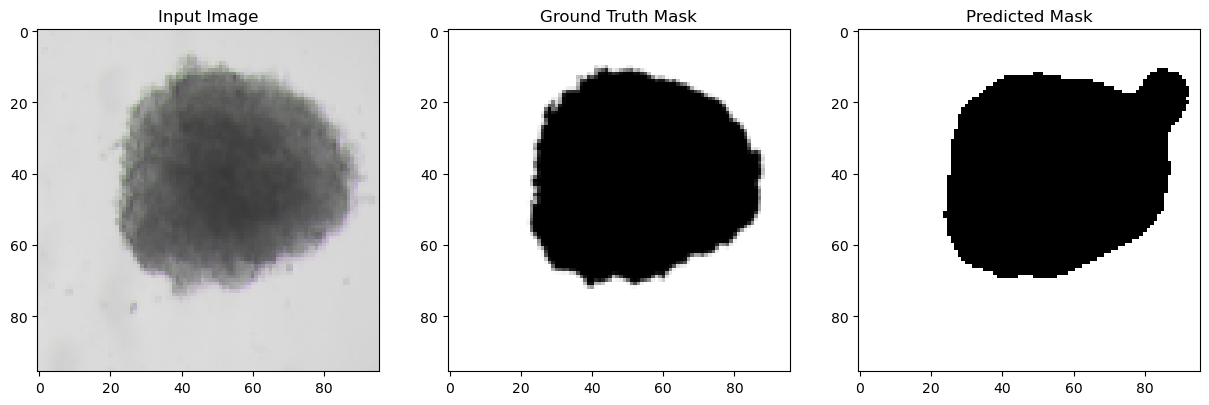

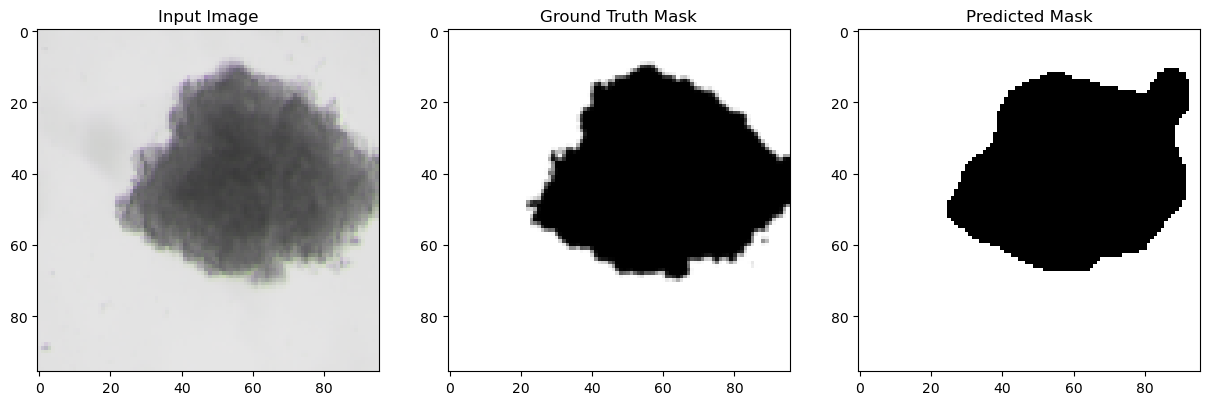

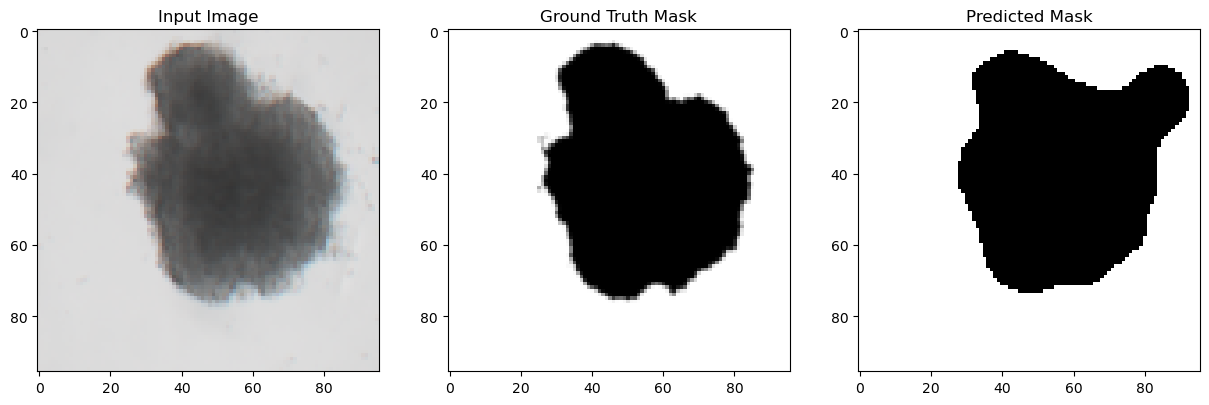

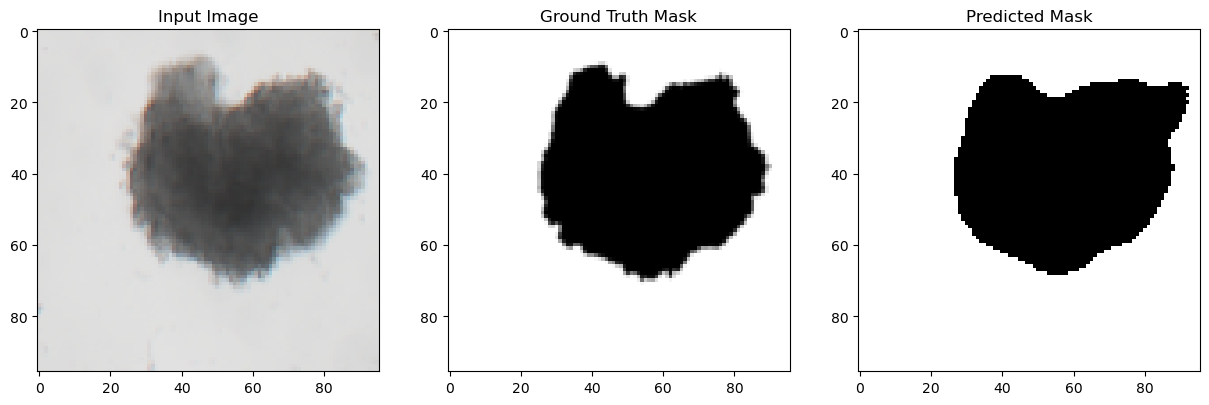

In [7]:

# Save model
#torch.save(model.state_dict(), 'unet_segmentation_model.pth')

# Visualize results
model.eval()
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)
outputs = model(images)
predicted_masks = (torch.sigmoid(outputs) > 0.5).float()

for i in range(len(images)):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(images[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(masks[i].cpu().squeeze(0).numpy(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_masks[i].cpu().squeeze(0).numpy(), cmap='gray')
    plt.show()


# Evaluation metrics added code

In [1]:
import os
import numpy as np
import tifffile as tiff
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryJaccardIndex

c:\Users\k54739\.conda\envs\master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DiceCoefficient:
    def __call__(self, pred, target, device):
        pred = (torch.sigmoid(pred) > 0.5).float().to(device)
        target = target.to(device)
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2.0 * intersection + 1e-6) / (union + 1e-6)
        return dice

In [3]:
def jaccard_index(prediction, target, threshold=0.5):
    """
    Computes the Jaccard index (IoU) between prediction and target masks.
    
    Args:
    - prediction (torch.Tensor): The predicted mask (output of model).
    - target (torch.Tensor): The ground truth mask (target).
    - threshold (float): Threshold to binarize the predicted mask. Default is 0.5 (for sigmoid outputs).
    
    Returns:
    - IoU (float): The Jaccard index (IoU).
    """
    # Apply sigmoid and threshold to get the binary prediction mask
    prediction = torch.sigmoid(prediction) > threshold
    
    # Flatten both prediction and target tensors
    prediction = prediction.view(-1).float()
    target = target.view(-1).float()
    
    # Compute intersection and union
    intersection = torch.sum(prediction * target)  # Element-wise multiplication (AND)
    union = torch.sum(prediction) + torch.sum(target) - intersection  # Element-wise addition (OR)
    
    # Compute IoU
    iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
    
    return iou

In [4]:
# Segmentation dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(('.tiff', '.tif'))]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(image_name)[0] + '_mask.tiff')

        # Load image and mask
        image = tiff.imread(image_path)
        mask = tiff.imread(mask_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {image_path} does not have exactly 3 layers.")

        mask = mask[np.newaxis, ...]  # Add channel dimension to mask

        # Normalize image and mask
        image = image.astype(np.float32) / 65535.0
        mask = mask.astype(np.float32) / 65535.0

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        # Resize image and mask to 96x96
        image = resize(image, size=(96, 96))
        mask = resize(mask, size=(96, 96))

        return image, mask


In [5]:
# Paths
image_dir = r'C:\Users\k54739\Today_data\segmentation\test_img'
mask_dir = r'C:\Users\k54739\Today_data\segmentation\test_mask'

# Dataset and DataLoader
all_images = os.listdir(image_dir)
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)
train_dataset = SegmentationDataset(image_dir, mask_dir)
val_dataset = SegmentationDataset(image_dir, mask_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [6]:
# Load pretrained U-Net model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Initialize metrics
dice_coefficient = DiceCoefficient()

Using cache found in C:\Users\k54739/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [7]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
train_iou_scores = []
val_iou_scores = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_dice_score = 0.0
    train_iou_score = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice_score += dice_coefficient(outputs, masks, device).item()
        train_iou_score += jaccard_index(outputs, masks).item()

    # Append the average train loss and metrics for the epoch
    train_losses.append(train_loss / len(train_loader))
    train_dice_scores.append(train_dice_score / len(train_loader))
    train_iou_scores.append(train_iou_score / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_dice_score = 0.0
    val_iou_score = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate metrics
            val_dice_score += dice_coefficient(outputs, masks, device).item()
            val_iou_score += jaccard_index(outputs, masks).item()

    # Append the average validation loss and metrics for the epoch
    val_losses.append(val_loss / len(val_loader))
    val_dice_scores.append(val_dice_score / len(val_loader))
    val_iou_scores.append(val_iou_score / len(val_loader))

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Dice: {train_dice_scores[-1]:.4f}, Train IoU: {train_iou_scores[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Dice: {val_dice_scores[-1]:.4f}, Val IoU: {val_iou_scores[-1]:.4f}")


Epoch 1/100, Train Loss: 0.6503, Train Dice: 0.8135, Train IoU: 0.6857, Val Loss: 0.6600, Val Dice: 0.8135, Val IoU: 0.6857
Epoch 2/100, Train Loss: 0.6047, Train Dice: 0.8080, Train IoU: 0.6778, Val Loss: 0.5829, Val Dice: 0.8135, Val IoU: 0.6857
Epoch 3/100, Train Loss: 0.5789, Train Dice: 0.7432, Train IoU: 0.5914, Val Loss: 0.5202, Val Dice: 0.8135, Val IoU: 0.6857
Epoch 4/100, Train Loss: 0.5589, Train Dice: 0.7515, Train IoU: 0.6019, Val Loss: 0.5108, Val Dice: 0.8134, Val IoU: 0.6855
Epoch 5/100, Train Loss: 0.5447, Train Dice: 0.7579, Train IoU: 0.6102, Val Loss: 0.5102, Val Dice: 0.8117, Val IoU: 0.6831
Epoch 6/100, Train Loss: 0.5354, Train Dice: 0.7607, Train IoU: 0.6139, Val Loss: 0.5121, Val Dice: 0.8098, Val IoU: 0.6804
Epoch 7/100, Train Loss: 0.5266, Train Dice: 0.7666, Train IoU: 0.6215, Val Loss: 0.5129, Val Dice: 0.8062, Val IoU: 0.6753
Epoch 8/100, Train Loss: 0.5184, Train Dice: 0.7769, Train IoU: 0.6353, Val Loss: 0.5132, Val Dice: 0.8906, Val IoU: 0.8028
Epoch 9/

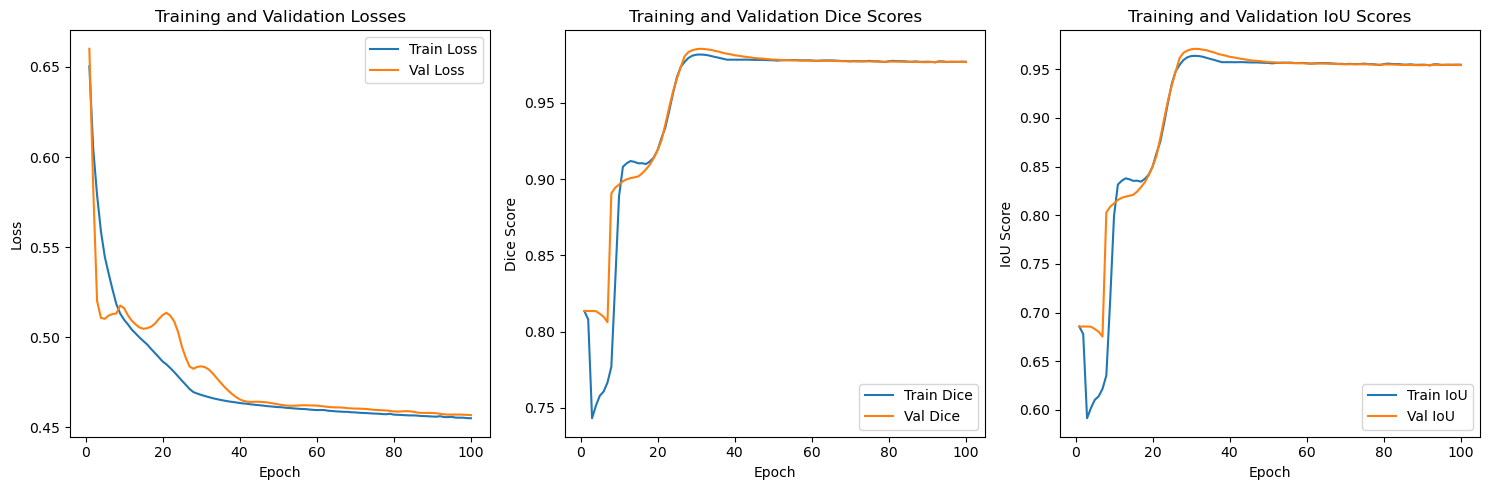

In [8]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

# Plotting Losses
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Dice Scores
plt.subplot(1, 3, 2)
plt.plot(epochs, train_dice_scores, label='Train Dice')
plt.plot(epochs, val_dice_scores, label='Val Dice')
plt.title('Training and Validation Dice Scores')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

# Plotting IoU Scores
plt.subplot(1, 3, 3)
plt.plot(epochs, train_iou_scores, label='Train IoU')
plt.plot(epochs, val_iou_scores, label='Val IoU')
plt.title('Training and Validation IoU Scores')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

plt.tight_layout()
plt.show()

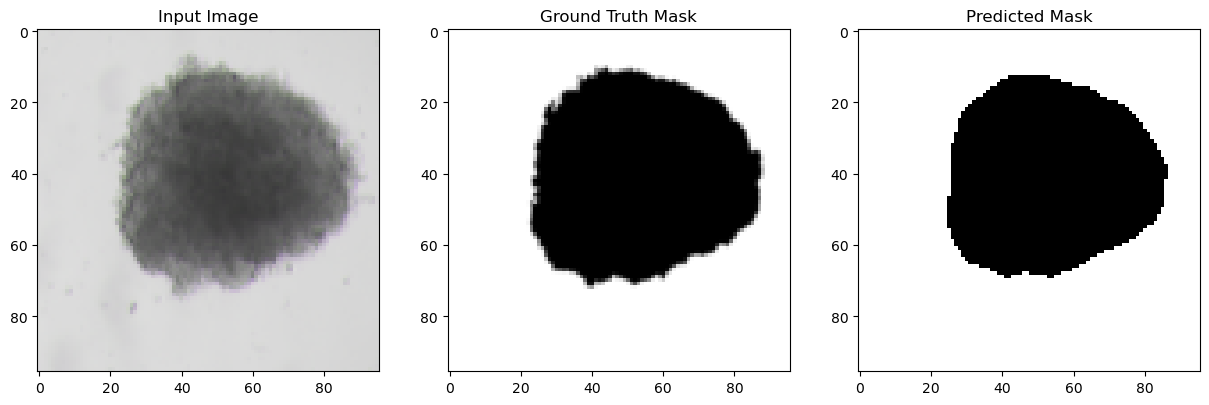

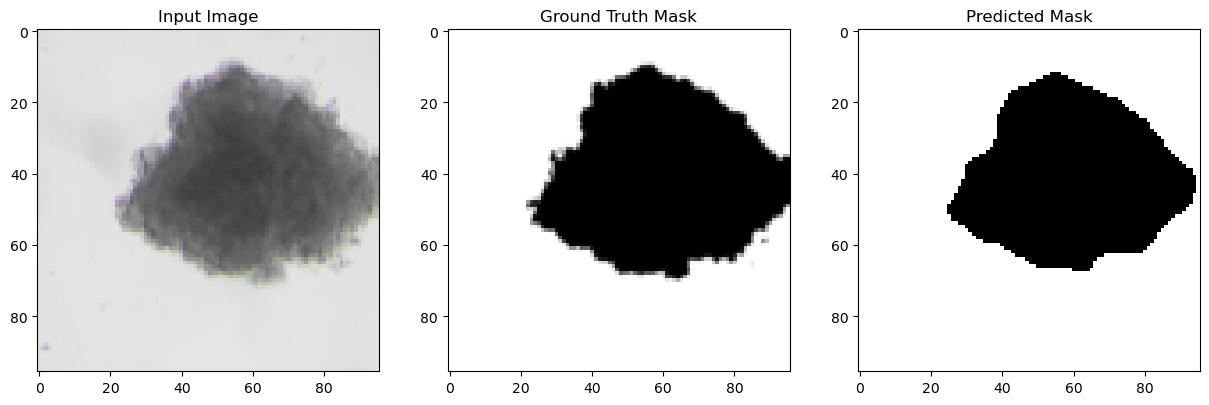

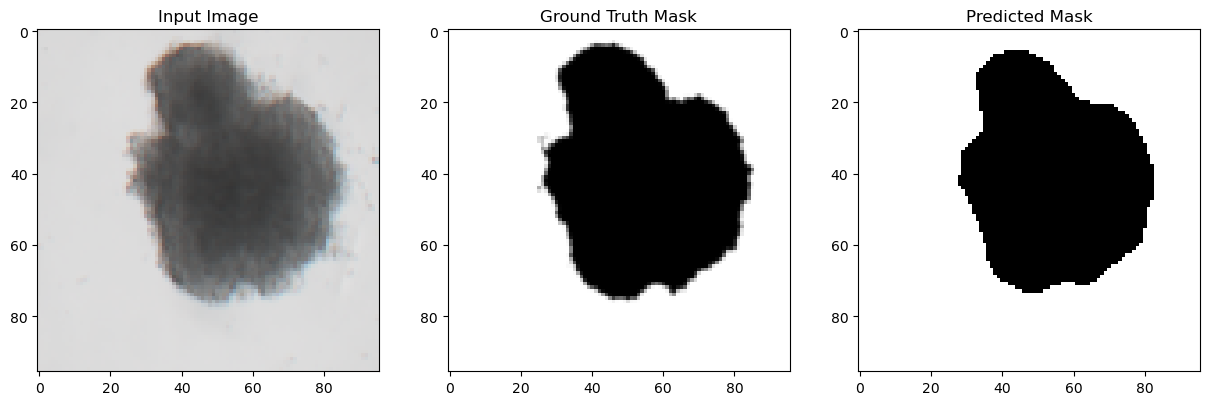

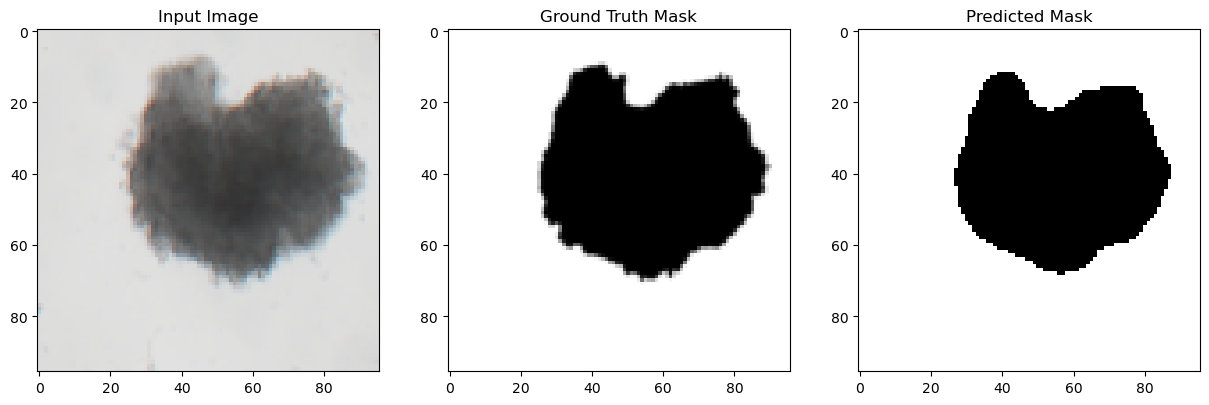

In [9]:
# Visualize results
model.eval()
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)
outputs = model(images)
predicted_masks = (torch.sigmoid(outputs) > 0.5).float()

for i in range(len(images)):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(images[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(masks[i].cpu().squeeze(0).numpy(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_masks[i].cpu().squeeze(0).numpy(), cmap='gray')
    plt.show()